In [3]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
with open('C:/Users/kzadk/OneDrive/Desktop/YT_api_key.txt') as f:
    key = f.read()

api_key = key
api_service_name = 'youtube'
api_version = 'v3' 

youtube = build(api_service_name, api_version, developerKey=api_key)

# List of ids of channels that we picked for analyze
channel_ids = ['UCCezIgC97PvUuR4_gbFUs5g', # Corey Shafer
               'UCcIXc5mJsHVYTZR1maL5l9w', # DeepLearningAI
               'UCr8O8l5cCX85Oem1d18EezQ', # DanielBourke
               'UCfzlCWGWYyIQ0aLC5w48gBQ', # Sentdex
               'UCtYLUTtgS3k1Fg4y5tAhLbw', # StatQuest
               'UCYO_jab_esuFRV4b17AJtAw' # 3Blue1Brown
               ]


### Function to get desired channels statistics


In [5]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet, contentDetails, statistics',
        id = ','.join(channel_ids))
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)

    return all_data

In [6]:
data = get_channel_stats(youtube, channel_ids)

In [7]:
len(data)

6

In [8]:
yt_data = pd.DataFrame(data)

In [9]:
yt_data

,Channel_name,Subscribers,Views,playlist_id
0,DeepLearningAI,231000,14646197,UUcIXc5mJsHVYTZR1maL5l9w
1,Daniel Bourke,156000,7472054,UUr8O8l5cCX85Oem1d18EezQ
2,3Blue1Brown,5290000,346474843,UUYO_jab_esuFRV4b17AJtAw
3,StatQuest with Josh Starmer,955000,50842364,UUtYLUTtgS3k1Fg4y5tAhLbw
4,Corey Schafer,1150000,86964220,UUCezIgC97PvUuR4_gbFUs5g
5,sentdex,1250000,110546824,UUfzlCWGWYyIQ0aLC5w48gBQ


In [10]:
yt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Channel_name  6 non-null      object
 1   Subscribers   6 non-null      object
 2   Views         6 non-null      object
 3   playlist_id   6 non-null      object
dtypes: object(4)
memory usage: 320.0+ bytes


#### Converting data types

In [11]:
yt_data['Subscribers'] = pd.to_numeric(yt_data['Subscribers'])
yt_data['Views'] = pd.to_numeric(yt_data['Views'])

In [12]:
yt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Channel_name  6 non-null      object
 1   Subscribers   6 non-null      int64 
 2   Views         6 non-null      int64 
 3   playlist_id   6 non-null      object
dtypes: int64(2), object(2)
memory usage: 320.0+ bytes


### Showing plots for numerical data of channels


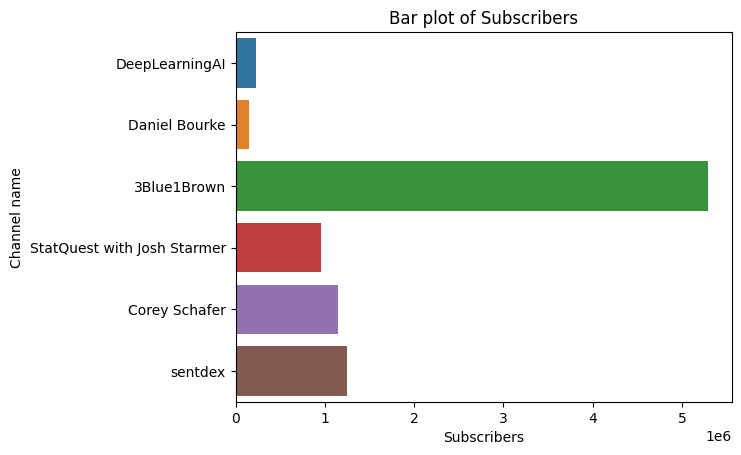

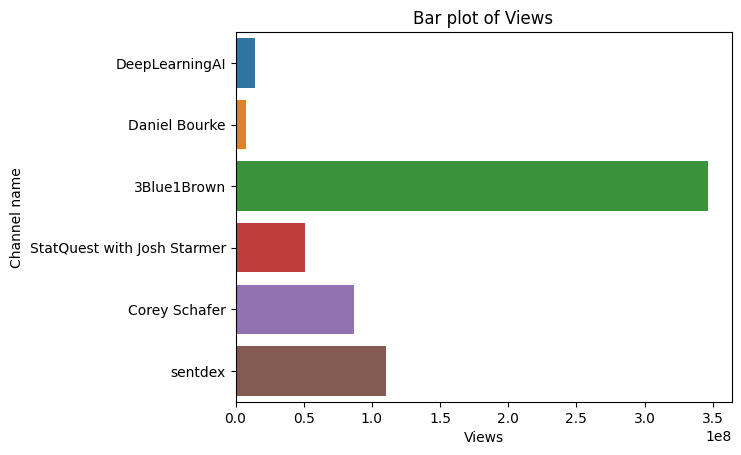

In [13]:
for column in yt_data.columns:
    if yt_data[column].dtype.kind in 'iufc':
        sns.barplot(x=yt_data[column], y=yt_data['Channel_name'])
        plt.xlabel(column)
        plt.ylabel('Channel name')
        plt.title(f'Bar plot of {column}')
        plt.show()

### Function to get ids of videos from specific channel


In [14]:
playlist_id = yt_data.loc[yt_data['Channel_name'] == '3Blue1Brown', 'playlist_id'].iloc[0]

In [15]:
playlist_id

'UUYO_jab_esuFRV4b17AJtAw'

In [16]:
def get_channel_videos_ids(youtube, playlist_id):

    request = youtube.playlistItems().list(
        part = 'contentDetails',
        playlistId = playlist_id,
        maxResults = 50)
    response = request.execute()

    videos_ids = []

    for i in range(len(response['items'])):
        videos_ids.append(response['items'][i]['contentDetails']['videoId'])

    # This section is here becouse of the pagination system(max 50 results per page)
    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part = 'contentDetails',
                playlistId = playlist_id,
                maxResults = 50,
                pageToken = next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                videos_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
    return videos_ids

In [17]:
videos_ids = get_channel_videos_ids(youtube, playlist_id)

In [18]:
len(videos_ids)

131

### Function to get details of videos

In [30]:
def get_videos_details(youtube, videos_ids):

    all_video_stats = []

    # Again max 50 results, so we are looping using steps
    for i in range(0, len(videos_ids), 50):
        request = youtube.videos().list(
            part = 'snippet, statistics',
            id = ','.join(videos_ids[i : i + 50]))
        response = request.execute()

        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'][: 69],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount'])
            all_video_stats.append(video_stats)

    return all_video_stats

In [31]:
videos_details = get_videos_details(youtube, videos_ids)

In [21]:
len(videos_details)

131

In [33]:
videos_data = pd.DataFrame(videos_details)

In [34]:
videos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           131 non-null    object
 1   Published_date  131 non-null    object
 2   Views           131 non-null    object
 3   Likes           131 non-null    object
 4   Comments        131 non-null    object
dtypes: object(5)
memory usage: 5.2+ KB


#### Converting data types

In [35]:
videos_data['Published_date']

0      2023-07-02T04:41:01Z
1      2023-06-28T19:17:11Z
2      2023-06-27T15:08:14Z
3      2023-04-02T15:30:13Z
4      2023-03-14T18:36:36Z
               ...         
126    2015-08-14T01:20:50Z
127    2015-06-21T06:05:43Z
128    2015-04-11T08:19:03Z
129    2015-03-05T06:15:23Z
130    2015-03-05T06:15:22Z
Name: Published_date, Length: 131, dtype: object

In [36]:
videos_data['Published_date'] = pd.to_datetime(videos_data['Published_date']).dt.strftime('%Y-%m-%d')
videos_data['Published_date'] = pd.to_datetime(videos_data['Published_date'])
videos_data['Views'] = pd.to_numeric(videos_data['Views'])
videos_data['Likes'] = pd.to_numeric(videos_data['Likes'])
videos_data['Comments'] = pd.to_numeric(videos_data['Comments'])

In [26]:
videos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Title           131 non-null    object        
 1   Published_date  131 non-null    datetime64[ns]
 2   Views           131 non-null    int64         
 3   Likes           131 non-null    int64         
 4   Comments        131 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.2+ KB


#### Getting the top 10 videos based on the views

In [37]:
top10_videos = videos_data.sort_values(by='Views', ascending=False).head(10)

In [38]:
top10_videos

,Title,Published_date,Views,Likes,Comments
48,But what is a Fourier series? From heat flow ...,2019-06-30,16569490,160035,3975
74,The hardest problem on the hardest test,2017-12-08,14913450,390487,20142
83,But how does bitcoin actually work?,2017-07-07,14907290,344974,28471
78,"But what is a neural network? | Chapter 1, Dee...",2017-10-05,13983928,352546,6736
55,The most unexpected answer to a counting puzzle,2019-01-13,10836004,279226,5931
12,Solving Wordle using information theory,2022-02-06,9730865,211006,8724
71,But what is the Fourier Transform? A visual i...,2018-01-26,9154851,266353,8415
96,The essence of calculus,2017-04-28,7815565,218756,6487
56,But why is a sphere's surface area four times ...,2018-12-02,6968892,134209,4567
118,"Vectors | Chapter 1, Essence of linear algebra",2016-08-06,6822248,135624,3009


Text(0.5, 1.0, 'Top 10 videos by views')

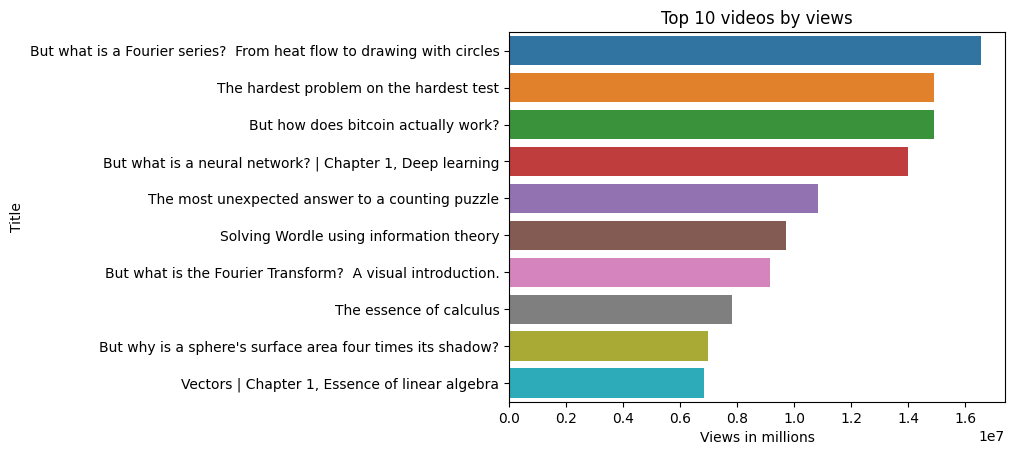

In [39]:
ax =  sns.barplot(x='Views', y='Title', data=top10_videos)
plt.xlabel('Views in millions')
plt.title('Top 10 videos by views')

#### Checking how many videos that channel has published monthly by adding extra column fot months

In [149]:
videos_data['Month'] = pd.to_datetime(videos_data['Published_date']).dt.strftime('%b')

In [150]:
videos_data

,Title,Published_date,Views,Likes,Comments,Month
0,Why π is in the normal distribution (beyond in...,2023-04-02,964204,36922,1389,Apr
1,But what is the Central Limit Theorem?,2023-03-14,2149056,46623,1835,Mar
2,But what is a convolution?,2022-11-18,1762386,75764,2305,Nov
3,Researchers thought this was a bug (Borwein in...,2022-11-04,1826462,58220,1765,Nov
4,"We ran a contest for math explainers, here are...",2022-10-01,693610,35958,1104,Oct
...,...,...,...,...,...,...
124,Euler's Formula and Graph Duality,2015-06-21,434787,10398,342,Jun
125,Circle Division Solution,2015-05-24,535768,16125,638,May
126,A Curious Pattern Indeed,2015-04-11,520658,10703,209,Apr
127,Euler's Formula Poem,2015-03-05,150313,4642,139,Mar


In [151]:
videos_per_month = videos_data.groupby('Month', as_index=False).size()

In [152]:
videos_per_month

,Month,size
0,Apr,16
1,Aug,16
2,Dec,9
3,Feb,4
4,Jan,6
5,Jul,8
6,Jun,7
7,Mar,12
8,May,21
9,Nov,11


#### 

#### Sorting by months as a categorical index

In [153]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [155]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'],
                                             categories=sort_order,
                                             ordered=True)

In [158]:
videos_per_month = videos_per_month.sort_index()

Text(0.5, 1.0, 'Videos per month')

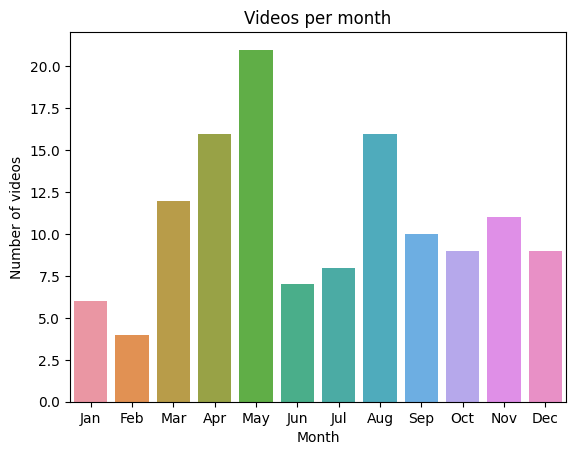

In [163]:
ax = sns.barplot(x='Month', y='size', data=videos_per_month)
plt.ylabel('Number of videos')
plt.title('Videos per month')